In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shelve
import random
from pandas import Series,DataFrame,read_csv, merge,concat,read_hdf
from omero.gateway import BlitzGateway
from matplotlib.widgets import Slider
from matplotlib import gridspec
from sklearn.externals import joblib


from sklearn import random_projection
import sklearn.neighbors as nn
import sklearn.manifold as man
import sklearn.decomposition as dec
from sklearn.preprocessing import scale,robust_scale
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib nbagg
plt.rcParams['image.cmap']='gray'

#hard coded dirs
h5path='/home/ubuntu/idr_homes/spli/szleo-h5'
dataDir='/home/ubuntu/data'

In [2]:
def imshowStack(st):
    z0=st.shape[2]/2
    fig, ax = plt.subplots(figsize=(10,10))
    plt.subplots_adjust(left=0.25, bottom=0.15)
    if len(st.shape)==4:
        imobj=plt.imshow(st[:,:,z0,:])
    else:
        imobj=plt.imshow(st[:,:,z0])
        
    axcolor = 'lightgoldenrodyellow'
    axz = plt.axes([0.25, 0.1, 0.65, 0.03], axisbg=axcolor)
    sz = Slider(axz, 'z', 0, st.shape[2], valinit=z0)
    def update(val):
        z = sz.val
        if len(st.shape)==4:
            imobj.set_data(st[:,:,z,:])
        else:
            imobj.set_data(st[:,:,z])
        fig.canvas.draw_idle()
    sz.on_changed(update)

    return sz

In [13]:
def goneFishing(pln,x,y,t,df,nbrs):
#    pln,x,y,t='plate1_1_013_5',504,384,220  #division at 220

    qry=df[(df.x==x) & (df.y==y) & (df.name==pln) & (df.t==t)].iloc[:,12:]

    dfq=df[df.name!=pln]
    w=dfq.w.iloc[0]
    h=dfq.h.iloc[0]
    chan=0
    
    spl=pln.split('_')
    plateName,wellNb=spl[0]+'_'+spl[1]+'_'+spl[2],int(spl[3])

    hook=getCondensationSubStack(wellNb,x,y,w,h,t,t+1,chan, plateName=plateName)    
    
    distances, indices = nbrs.kneighbors(qry)
    nnn=len(indices[0])
    tiles=np.zeros((h,w,nnn))
    for ind,ii in zip(indices[0],range(nnn)):
        wellNb=dfq.series.iloc[ind]
        x=dfq.x.iloc[ind]
        y=dfq.y.iloc[ind]
        t=dfq.t.iloc[ind]
        plateName=dfq['name'].iloc[ind]
        spl=plateName.split('_')
        plateName=spl[0]+'_'+spl[1]+'_'+spl[2]
        tiles[:,:,ii]=getCondensationSubStack(wellNb,x,y,w,h,t,t+1,chan, plateName=plateName) 

    
    d,r=divmod(nnn,4)
    plt.figure(figsize=(12,30))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
    ax0 = plt.subplot(gs[0,0])
#    ax0.set_title(title)
    ax0.imshow(hook)

    imc=buildComposite(tiles,d+(1&r),4,smpl=1)
#    plt.figure(figsize=(12,15))
    ax1 = plt.subplot(gs[1,0])
    ax1.imshow(imc)
    

In [4]:
def getCondensationSubStack(wellNb,x,y,w,h,ti,tf,chan=0, plateName=None,plateId=-1):
#    plateId,x,y,w,h,ti,tf=422,0,0,200,200,50,150
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()
        r,c=divmod(wellNb,12)
        if plateName==None:
            Q='''select well from Well as well 
            left outer join fetch well.wellSamples as ws 
            left outer join fetch ws.image as img 
            where well.plate.id = ''' + str(plateId)+ ' and well.row='+str(r)+' and well.column='+str(c)
        else:
            Q='''select well from Well as well 
            left outer join fetch well.wellSamples as ws 
            left outer join fetch ws.image as img 
            where well.plate.name = \'''' + plateName+ '\' and well.row='+str(r)+' and well.column='+str(c)

        well = conn.getQueryService().findAllByQuery(Q,None)[0]
        imid=well.getPrimaryWellSample().getImage().getId().getValue()

        im = conn.getObject("Image", imid)
        pix=im.getPrimaryPixels()

        z=0;c=chan;
        tile = (x, y, w, h) 
        zctList = [(z, c, it, tile) for it in range(ti,tf)]
        planes = pix.getTiles(zctList)
        st=[]
        for plane in planes:
            st.append(plane)

        st=np.asarray(st)
        if tf>ti+1:
            st=np.rollaxis(st,0,3)
        else:
            st=np.squeeze(st)
    finally:
        conn._closeSession()
    
    return st

In [5]:
def buildComposite(st,n,m,smpl=None):
    #nxm shots from st in a grid, as an image
    nr=st.shape[0]
    nc=st.shape[1]
    if smpl==None:
        smpl=st.shape[2]/(n*m)
    res=np.zeros((nr*n,nc*m))
    for i in range(n):
        for j in range(m):
            try:
                res[i*nr:i*nr+nr,j*nc:j*nc+nc]=st[:,:,(i*m+j)*smpl]
            except:
                break
    return res

In [6]:
def getImIDs(plns, wellNbs):
    lids=list()
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        for pln,wn in zip(plns,wellNbs):
            r,c=divmod(wn,12)
            Q='''select well from Well as well 
            left outer join fetch well.wellSamples as ws 
            left outer join fetch ws.image as img 
            where well.plate.name = \'''' + pln+ '\' and well.row='+str(r)+' and well.column='+str(c)

            im = conn.getQueryService().findAllByQuery(Q,None)[0].getPrimaryWellSample().getImage()
            lids.append(im.getId().getValue())
    finally:
        conn._closeSession()
    
    return lids

In [7]:
def getMapAnnotationsAsDicts(imids):
    la=list()
    try:
        conn = BlitzGateway('demo', 'cambridge', host='orca-3.openmicroscopy.org', port=4064)
        connected = conn.connect()

        for imid in imids:
            im= conn.getObject("Image",imid)
            a=im.getAnnotation()
            la.append(dict(a.getValue()))
    finally:
        conn._closeSession()
    
    return la


In [8]:
def outOneStack(pln,x,y, df,alg='PCA',chan=0,title=''):
#    pln='plate1_1_013_5'
#    x=504
#    y=384

    df=df[(df.x==x) & (df.y==y) & (df.name==pln)].sort_values('t',ascending=True)

    plt.figure(figsize=(12,30))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
    ax0 = plt.subplot(gs[0,0])
    ax0.set_title(title)
    if alg=='PCA':
        ax0.plot(df.PCA_0.values)
        ax0.plot(df.PCA_1.values,'r')
        ax0.plot(df.PCA_2.values,'g')
        ax0.plot(df.PCA_3.values,'y')
        ax0.plot(df.PCA_4.values,'m')
        ax0.plot(df.PCA_5.values,'c')
    elif alg=='DR':
        ax0.plot(df.DR_0.values)
        ax0.plot(df.DR_1.values,'r')
        ax0.plot(df.DR_2.values,'g')
        ax0.plot(df.DR_3.values,'y')
        ax0.plot(df.DR_4.values,'m')

    spl=pln.split('_')
    plateName,wellNb=spl[0]+'_'+spl[1]+'_'+spl[2],int(spl[3])

    x,y,w,h=x,y,df.w.min(),df.h.min()
    #plateId,wellNb,x,y,w,h=492,5,dfst.x.min(),dfst.y.min(),dfst.w.min(),dfst.h.min()
    ti,tf=df.t.min(),df.t.max()
    st=getCondensationSubStack(wellNb,x,y,w,h,ti,tf,chan, plateName=plateName)    
    
    imc=buildComposite(st,5,5)
#    plt.figure(figsize=(12,15))
    ax1 = plt.subplot(gs[1,0])
    ax1.imshow(imc)
    return st

## computing PCA

In [19]:
#PCA of 4 wells


_, _, filenames = next(os.walk(h5path), (None, None, []))
df=DataFrame()
for f in filenames[-4:]:
    f=os.path.join(h5path,f)
    df=concat((df,read_hdf(f)))
    
df=df[df.c==0]
dat=df.iloc[:,11:]
#keeping only the features which are not too discrete
#nbv=[len(dat[x].unique()) for x in df.iloc[:,12:]]
#dat=dat.iloc[:,np.array(nbv)>10]

dat=scale(dat)


pca=dec.PCA(n_components=250)
#pca=dec.RandomizedPCA(250)
#pca=dec.SparsePCA(250)
#pca=dec.KernelPCA(n_components=10,kernel='rbf')

pca.fit(dat)
datPCA=pca.transform(dat)
datPCA=DataFrame(datPCA)
datPCA.columns=['PCA_'+str(i) for i in range(datPCA.shape[1])]
df=df.reset_index(drop=True)
df=concat((df.iloc[:,0:11],datPCA),axis=1)
#transformer = random_projection.SparseRandomProjection(n_components=500)
#dat = transformer.fit_transform(dat)


Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate1_1_013_5_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate2_5_015_53_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate2_2_007_63_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate2_5_015_24_features.h5 in read-only mode


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [20]:
#projecting all other wells

_, _, filenames = next(os.walk(h5path), (None, None, []))
for f in filenames[:-4]:
    dfcur=DataFrame()
    f=os.path.join(h5path,f)
    dfcur=read_hdf(f)
    dfcur=dfcur[dfcur.c==0]
    dat=dfcur.iloc[:,11:]
    dat=scale(dat)
    datPCA=pca.transform(dat)
    datPCA=DataFrame(datPCA)
    datPCA.columns=['PCA_'+str(i) for i in range(datPCA.shape[1])]
    dfcur=dfcur.reset_index(drop=True)
    dfcur=concat((dfcur.iloc[:,0:11],datPCA),axis=1)
    df=concat((df,dfcur))
df=df.reset_index(drop=True)

Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate1_3_003_56_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate1_2_006_81_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate1_2_006_5_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate1_3_003_5_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate2_2_007_49_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate2_2_007_36_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate1_7_015_56_features.h5 in read-only mode


In [21]:
## adding all anotations, ie gene name


def name2plateName(pln):
    spl=pln.split('_')
    return spl[0]+'_'+spl[1]+'_'+spl[2]



dfw=df[['name','series']].drop_duplicates()

dfw['plateName']=[name2plateName(s) for s in dfw['name']]

dfw['ID']=getImIDs(dfw['plateName'], dfw['series'])

dfw['Annotations']=getMapAnnotationsAsDicts(dfw['ID'])

l=list()
for i,row in df.iterrows():
    try:
        l.append(dfw[(dfw['name']==row['name'])&(dfw['series']==row['series'])]['Annotations'].iat[0]['Gene Symbol'])
    except:
        l.append('WT')
        
df.insert(0,'geneName',l)




In [29]:
df.to_hdf(os.path.join('data','PCA250features_testwells.h5'),'PCAfeatures')

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:257: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:257: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block1_items] [items->None]

  f(store)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:939: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['geneName', u'img_path', u'name', u'version']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:257: PerformanceWarning: 
your

In [13]:

joblib.dump(pca, os.path.join(dataDir,'PCA_4condentationwells.pkl') )

['data/PCA_4condentationwells.pkl',
 'data/PCA_4condentationwells.pkl_01.npy',
 'data/PCA_4condentationwells.pkl_02.npy',
 'data/PCA_4condentationwells.pkl_03.npy',
 'data/PCA_4condentationwells.pkl_04.npy']

In [11]:
pca= joblib.load(os.path.join(dataDir,'PCA_4condentationwells.pkl')) 
df=read_hdf(os.path.join(dataDir,'PCA250features_testwells.h5'))

## some display

In [31]:
#one tile at random

#pln,x,y='plate1_1_013_5',504,384  #division at 220
#pln,x,y='plate2_5_015_24',672,128  #nothing

#at random
geneName='CDK1'
x=random.choice(df.x.unique())
y=random.choice(df.y.unique())
pln=random.choice(df[df.geneName==geneName]['name'].unique())

st=outOneStack(pln,x,y, df,alg='PCA',chan=0,title=pln+'-'+str(x)+'-'+str(y))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


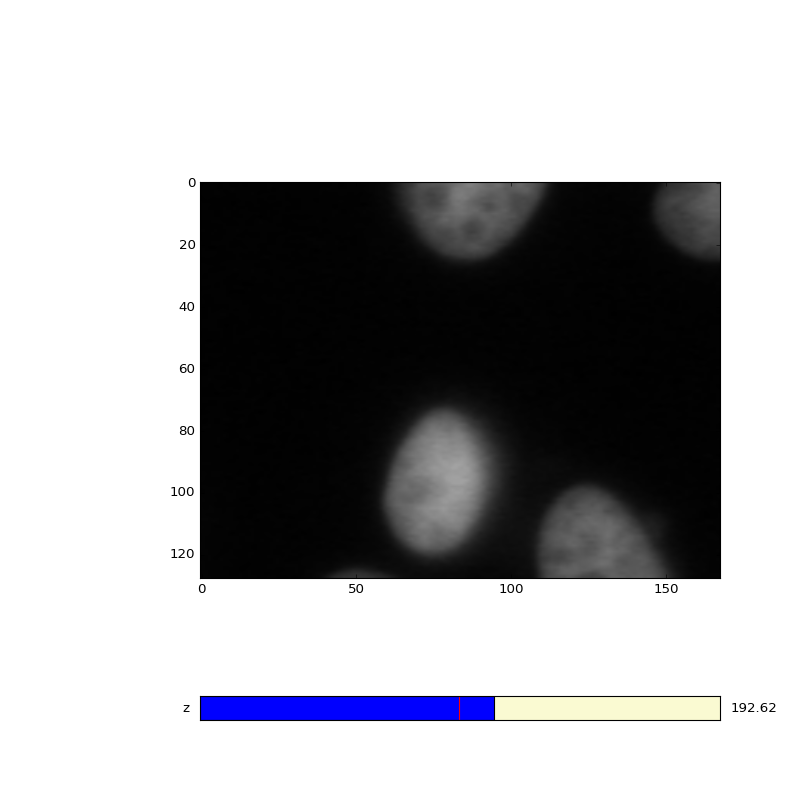

In [31]:
imshowStack(st)

<IPython.core.display.Javascript object>


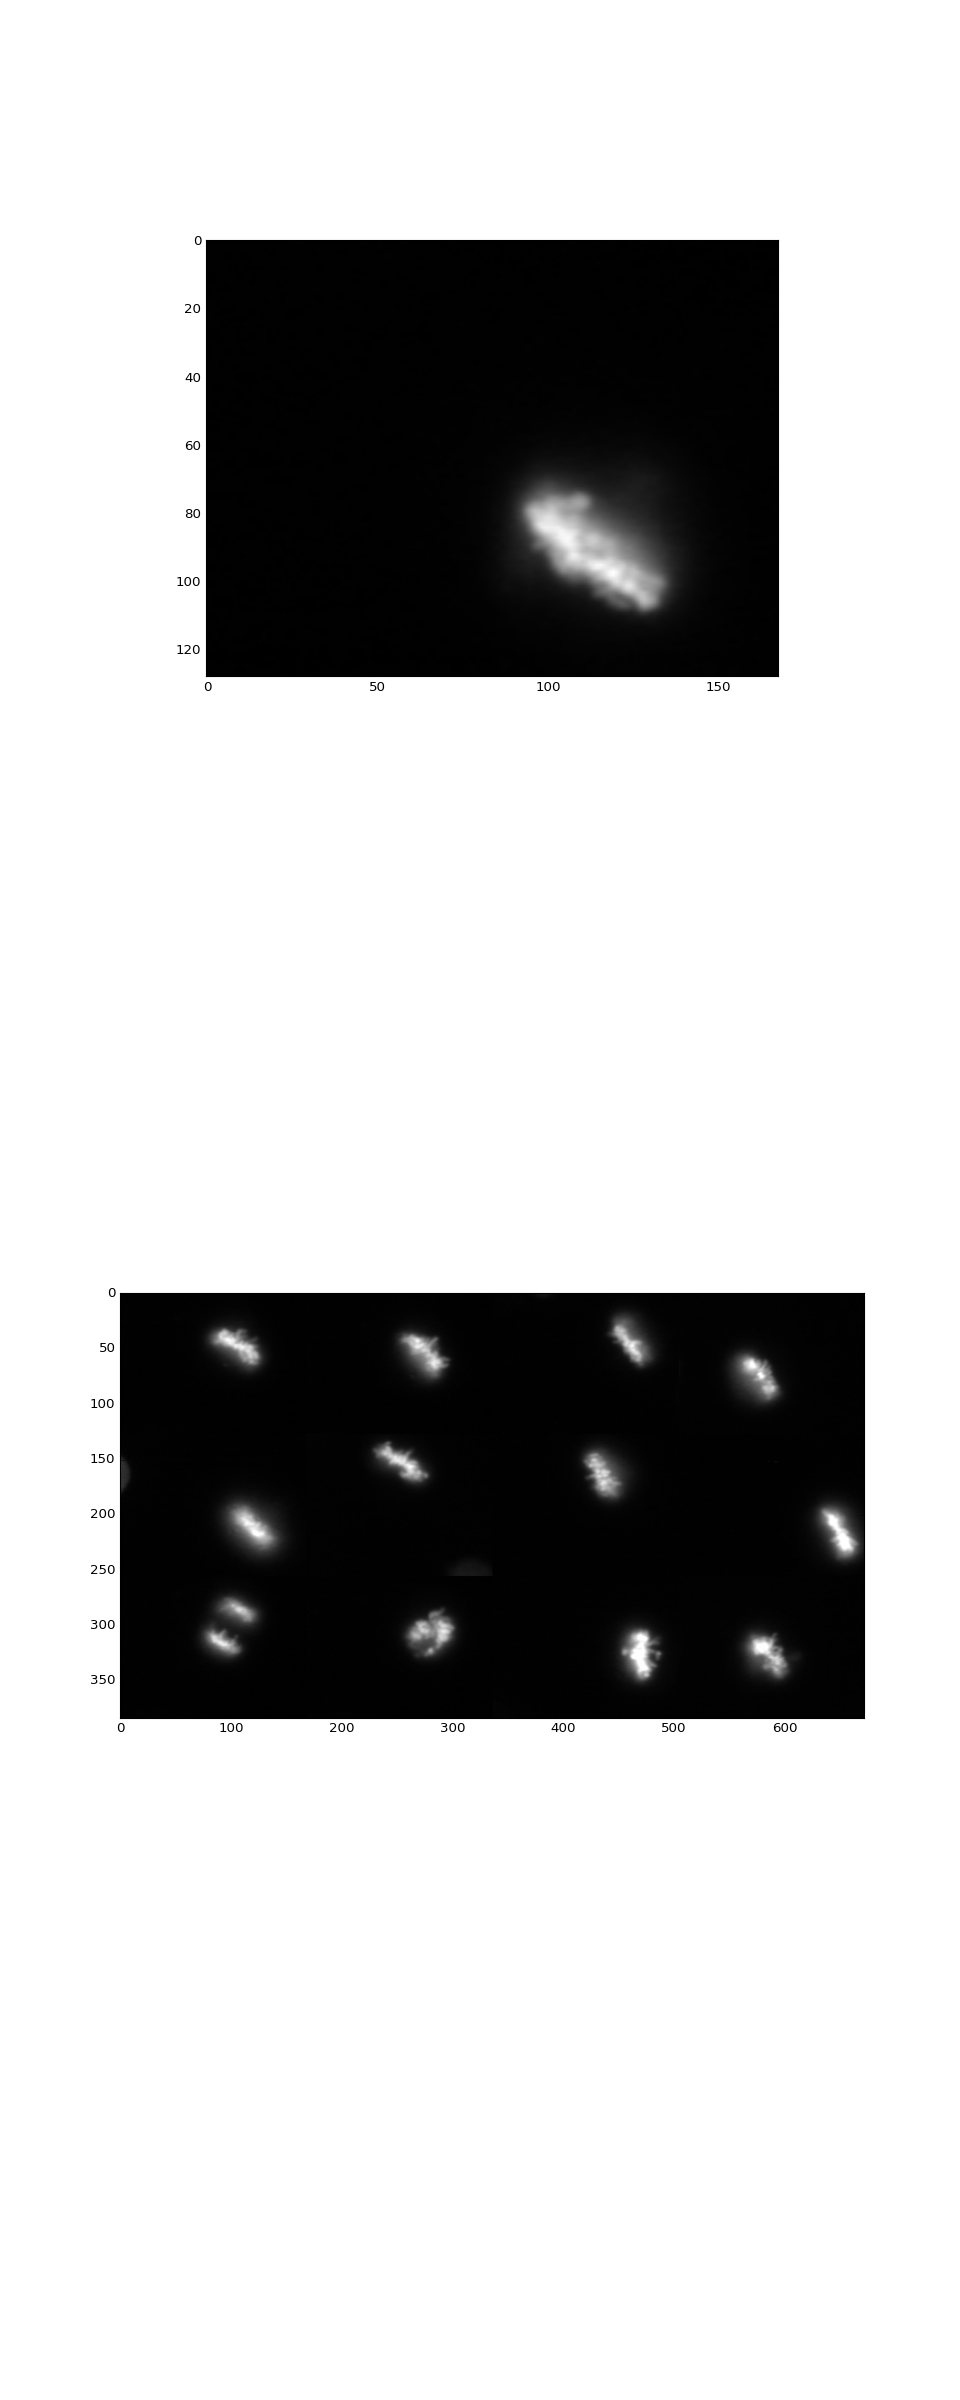

In [14]:
## Going fishing for NN

pln,x,y,t='plate1_1_013_5',504,384,220  #division at 220
#pln,x,y,t='plate1_2_006_5',168,896,66  #division at 30 and 66

#at random
#x=random.choice(df.x.unique())
#y=random.choice(df.y.unique())
#t=random.choice(range(df.t.max()))
#pln=random.choice(df['name'].unique())

dfq=df[df.name!=pln]
nbrs = nn.NearestNeighbors(n_neighbors=12, algorithm='ball_tree').fit(dfq.iloc[:,12:]) #was 11 before geneName got added


goneFishing(pln,x,y,t,df,nbrs)

## charm fishing

In [14]:

_, _, filenames = next(os.walk(h5path), (None, None, []))
df=DataFrame()
for f in filenames[-4:]:
    f=os.path.join(h5path,f)
    df=concat((df,read_hdf(f)))

df=df[df.c==0]
df.iloc[:,12:]=scale(df.iloc[:,12:])


Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate1_1_013_5_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate2_5_015_53_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate2_2_007_63_features.h5 in read-only mode
Opening /home/ubuntu/idr_homes/spli/szleo-h5/plate2_5_015_24_features.h5 in read-only mode


<IPython.core.display.Javascript object>


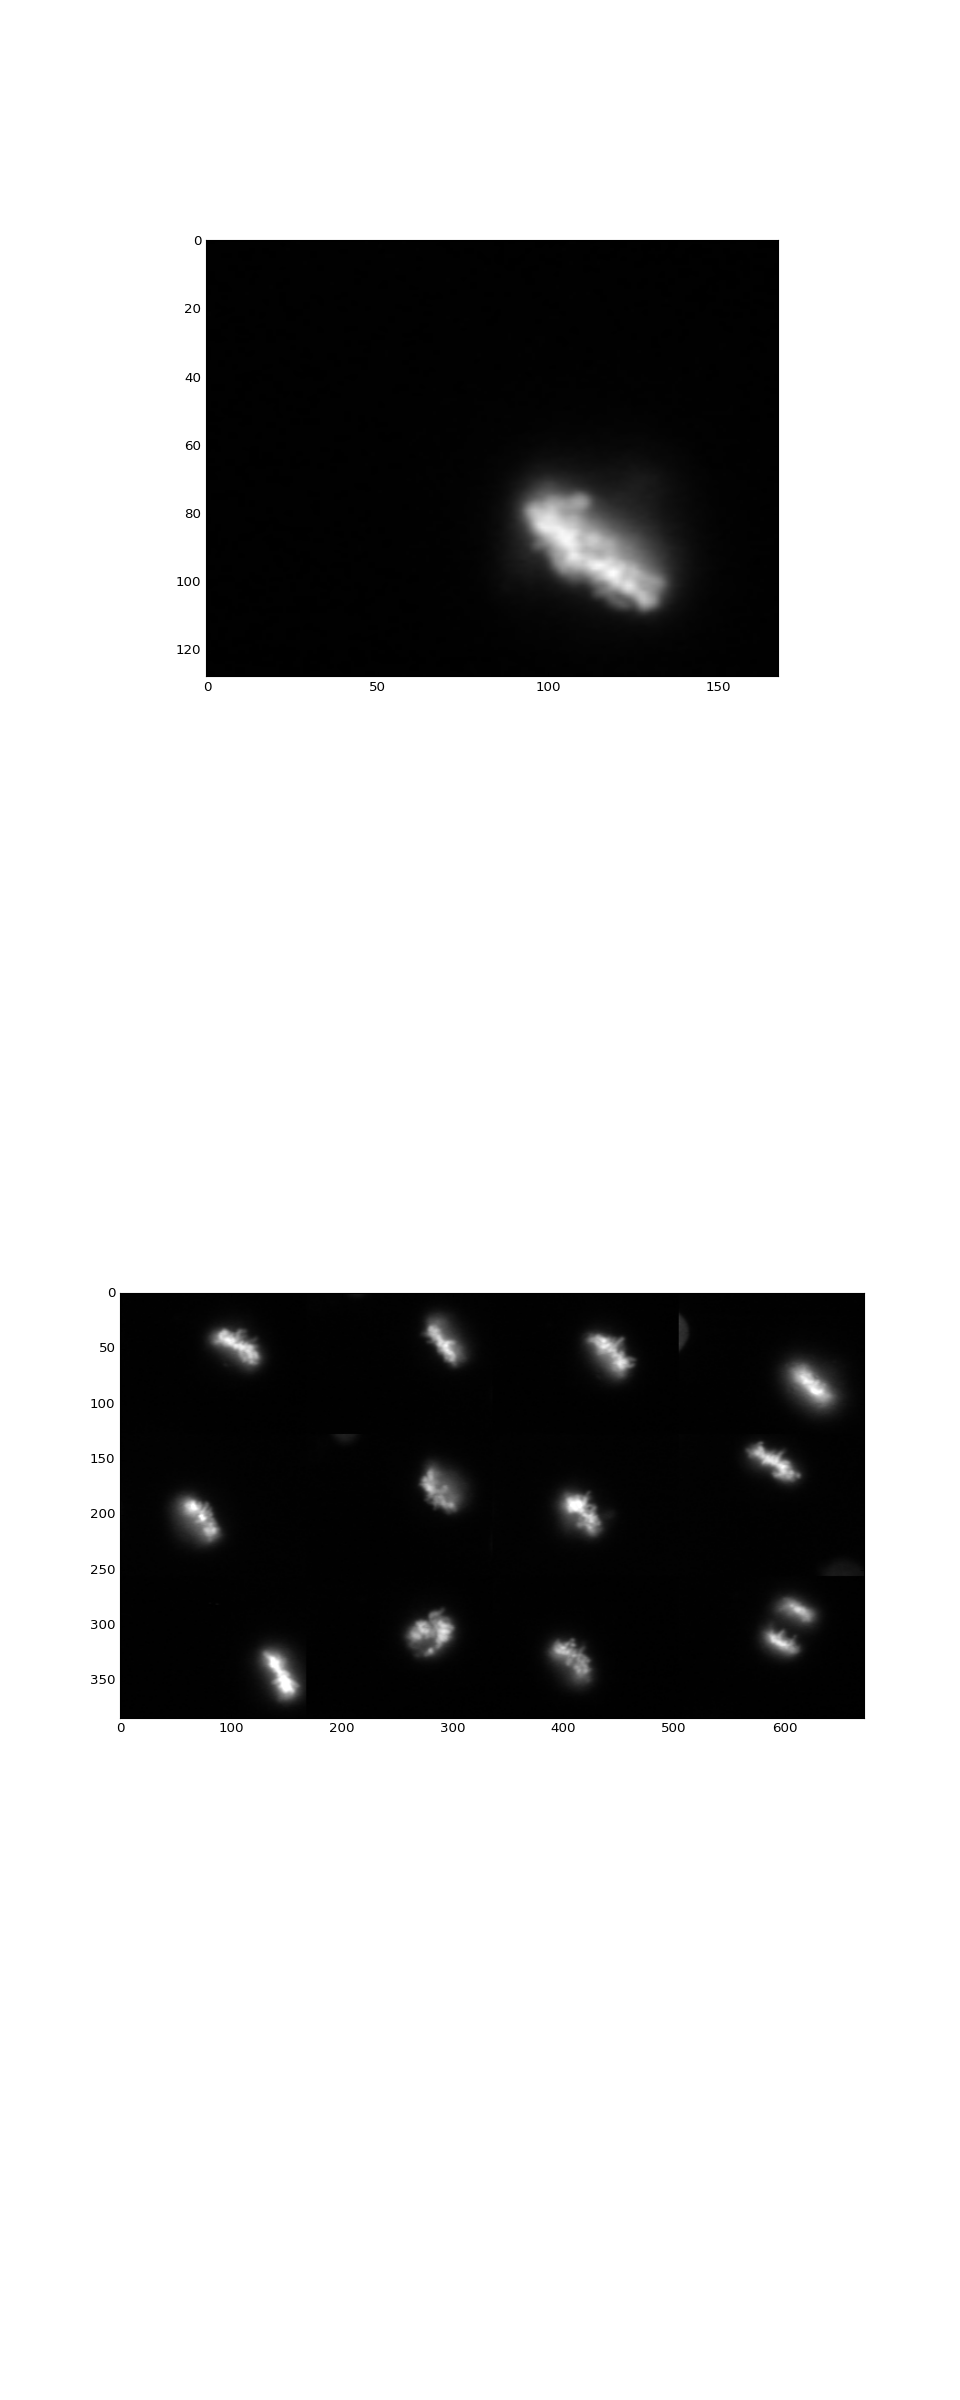

In [15]:


pln,x,y,t='plate1_1_013_5',504,384,220  #division at 220
#pln,x,y,t='plate1_2_006_5',168,896,66  #division at 30 and 66

#at random
#x=random.choice(df.x.unique())
#y=random.choice(df.y.unique())
#t=random.choice(range(df.t.max()))
#pln=random.choice(df['name'].unique())

dfq=df[df.name!=pln]
nbrs = nn.NearestNeighbors(n_neighbors=12, algorithm='ball_tree').fit(dfq.iloc[:,12:])


goneFishing(pln,x,y,t,df,nbrs)